In [14]:

import pandas as pd
import math 
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
import numpy as np
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
pd.options.mode.chained_assignment = None  
from pandas.plotting import scatter_matrix


#Import data
pd.set_option('display.max_columns', 500)
tit=pd.read_csv("https://raw.githubusercontent.com/chonorat/Titanic/master/titanictrain.csv")
test=pd.read_csv("https://raw.githubusercontent.com/chonorat/Titanic/master/titanictest.csv")


In [15]:

#Ticket_Sum
#This field sums the amount of identical ticket numbers
test["data"]="test"
tit["data"]="train"
tit2=tit
tit2=tit2.append(test, ignore_index=True)
tit2["PlaceHold"]=1
tit2['TicketSum'] = tit2['PlaceHold'].groupby(tit2['Ticket']).transform('sum')
tit2["SibSp"]=tit2.SibSp.fillna(tit2.SibSp.median())
grouped = tit2.groupby(['Sex','Pclass'])  
tit2["Age"]=grouped.Age.fillna(tit2.Age.mean())
tit2["Pclass"]=tit2.Pclass.fillna(tit2.Pclass.median())
test = tit2[tit2['data'] =="test"]
tit = tit2[tit2['data'] =="train"]

In [16]:
#Split data for Survived/Died plots
tit["Age"]=tit.Age.fillna(tit.Age.mean())
test["Age"]=test.Age.fillna(test.Age.mean())
Survived=tit.loc[tit['Survived'] == 1]
Died=tit.loc[tit['Survived'] == 0]

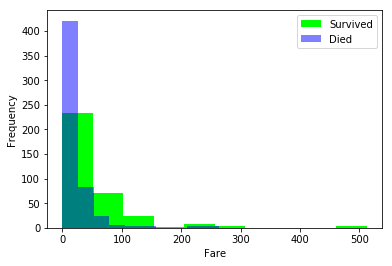

In [17]:

#fare
#Passengers who paid less appear to die at a higher rate
test["Fare"]=test.Fare.fillna(test.Fare.median())
tit["Fare"]=tit.Fare.fillna(tit.Fare.median())
plt.figure(1)
plt.hist(Survived.Fare,label='Survived',fc=(0, 1, 0, 1))
plt.hist(Died.Fare,label='Died',fc=(0, 0, 1, 0.5))
plt.legend(loc='upper right')
plt.xlabel('Fare')
plt.ylabel('Frequency')
plt.show(1)


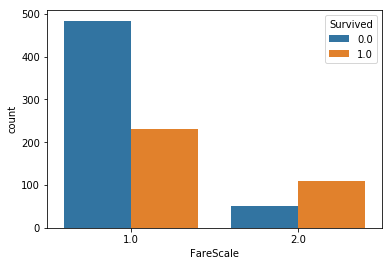

In [18]:
#Scaled values for fare
def fare_scale(tit, test):
    for i in [tit, test]:
        bins = [0, 50, 100,200,300, 500, np.inf]
        names = ['<50', '50-100','100-200','200-300', '300-500', '500+']
        i['FareRange'] = pd.cut(tit['Fare'], bins, labels=names)
        i["FareScale"]=i.FareRange.replace({'<50':1, '50-100':2,'100-200':2,'200-300':2, '300-500':2, '500+':2})
fare_scale(tit,test)

plt.figure()
sns.countplot(x="FareScale",hue="Survived", data=tit)


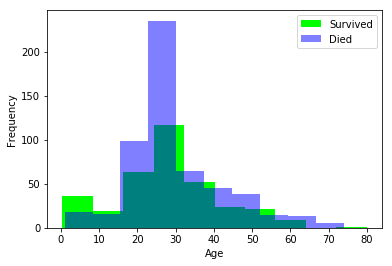

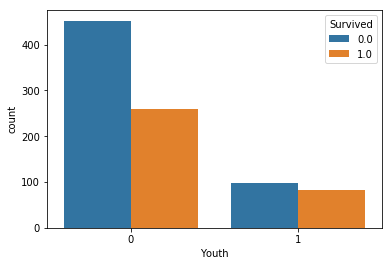

In [19]:
#Youth
#Individuals under appear to have the highest survival rate
plt.figure(2)
plt.hist(Survived.Age,label='Survived',fc=(0, 1, 0, 1))
plt.hist(Died.Age,label='Died',fc=(0, 0, 1, 0.5))
plt.legend(loc='upper right')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show(2)

tit["Youth"]=1
tit.loc[tit.Age>20,"Youth"]=0
test["Youth"]=1
test.loc[test.Age>20,"Youth"]=0
plt.figure()
sns.countplot(x='Youth',hue="Survived", data=tit)


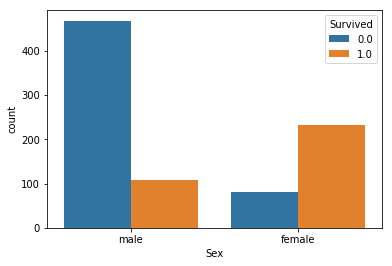

In [20]:
#sex
#Men certaintly died at a much higher rate
sex_dummies=pd.get_dummies(tit["Sex"],prefix="Sex")
tit=tit.join(sex_dummies)
sex_dummies1=pd.get_dummies(test["Sex"],prefix="Sex")
test=test.join(sex_dummies1)

plt.figure()
sns.countplot(x='Sex',hue="Survived", data=tit)


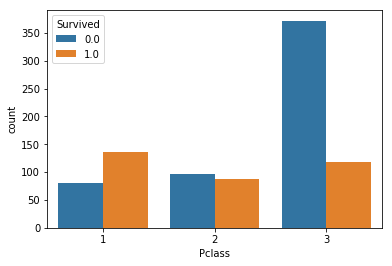

In [21]:

#Pclass
#1st and 2nd class have a similar survival rate while the survival rate for 3rd class is drastically lower.
plt.figure()
sns.countplot(x='Pclass',hue="Survived", data=tit)


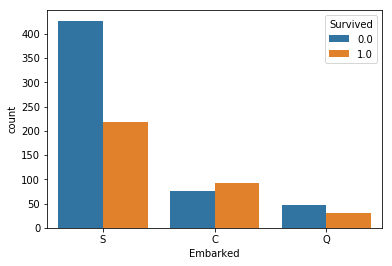

In [22]:
#Embarked
#Individuals who embarked brom "C" had the highest survival rate
def embarked_impute(tit, test):
    for i in [tit, test]:
        i['Embarked'] = i['Embarked'].fillna('S')
embarked_impute(tit,test)

plt.figure()
sns.countplot(x='Embarked',hue="Survived", data=tit)



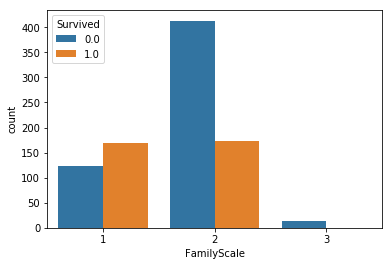

In [23]:
#famliysize
#Converted family size into a scaled category
def family_scale(tit, test):
    for i in [tit, test]:    
        i["j"]=i.SibSp+i.Parch
        i["FamilyScale"]=i.j.replace({3:1,2:1,1:1,0:2,4:2,5:2,6:2,7:3,10:3})
family_scale(tit,test)

plt.figure()
sns.countplot(x='FamilyScale',hue="Survived", data=tit)


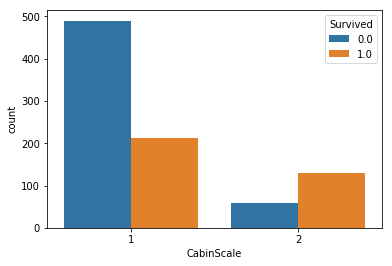

In [24]:
#Cabin
#Converted cabin letter to a scaled category.  Passengers with unkown cabins died at the highest rate.
def cabin_num(tit, test):
    for i in [tit, test]:
        i.Cabin = i.Cabin.fillna('Z')
        i['CA'] = i['Cabin'].astype(str).str[0]
        i["CabinScale"]=i.CA.replace({"Z": 1,"C": 2,"E": 2,"D": 2,"B": 2,"G": 2,"A": 1,"F": 2,"T": 1})
cabin_num(tit,test)

plt.figure()
sns.countplot(x='CabinScale',hue="Survived", data=tit)


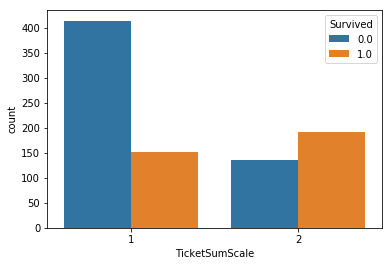

In [25]:
#ticketsum
#Converted the sum of ticket numbers into a scaled category
def ticketgroup_scale(tit, test):
    for i in [tit, test]:
        i["TicketSumScale"]=i.TicketSum.replace({11:1,7:1,6:1,5:1,8:1,1:1,2:2,3:2,4:2})
        i["TicketSumScale"]=i.TicketSum.replace({11:1,7:1,6:1,5:1,8:1,1:1,2:2,3:2,4:2})
ticketgroup_scale(tit,test)

plt.figure()
sns.countplot(x='TicketSumScale',hue="Survived", data=tit)


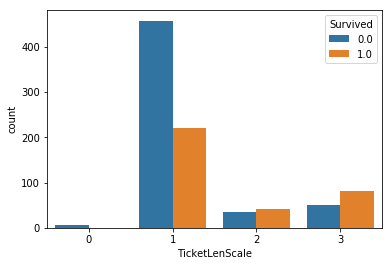

In [26]:
#ticketlength
#Converted ticket length into a scaled category
def ticketlen_scale(tit, test):
    for i in [tit, test]:
        i['TickLen']=i.Ticket.apply(len)
        i["TicketLenScale"]=i.TickLen.replace({5:3,8:2,3:1,4:1,6:1,7:1,9:1,10:1,11:1,12:1,13:1,15:1,16:1,17:1,18:0})
ticketlen_scale(tit,test)

plt.figure()
sns.countplot(x="TicketLenScale",hue="Survived", data=tit)


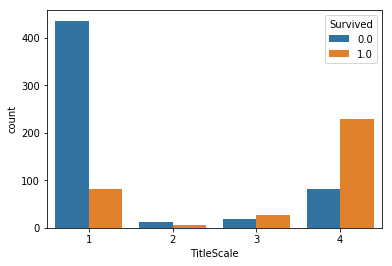

In [27]:
#Title
#Converted titles into a scaled category.  "Royalty" and "Mrs" had the highest survival rate.
def title_scale(tit, test):
    for i in [tit, test]:
        i['Title'] = i.Name.apply(lambda name: name.split(',')[1].split('.')[0].strip())
        i["titleform"]=i.Title.replace({
            "Capt":       "Officer",
            "Col":        "Officer",
            "Major":      "Officer",
            "Jonkheer":   "Royalty",
            "Don":        "Royalty",
            "Sir" :       "Royalty",
            "Dr":         "Officer",
            "Rev":        "Officer",
            "the Countess":"Royalty",
            "Dona":       "Royalty",
            "Mme":        "Mrs",
            "Mlle":       "Miss",
            "Ms":         "Mrs",
            "Mr" :        "Mr",
            "Mrs" :       "Mrs",
            "Miss" :      "Miss",
            "Master" :    "Master",
            "Lady" :      "Royalty"
            })
        i["TitleScale"]=i.titleform.replace({"Mr": 1,"Officer": 2,"Master": 3,"Royalty": 3,"Mrs": 4,"Miss": 4})
title_scale(tit, test)
plt.figure()
sns.countplot(x="TitleScale",hue="Survived", data=tit)


NameLen
(11.999, 19.0]    0.220588
(19.0, 23.0]      0.301282
(23.0, 27.0]      0.319797
(27.0, 32.0]      0.442424
(32.0, 82.0]      0.674556
Name: Survived, dtype: float64

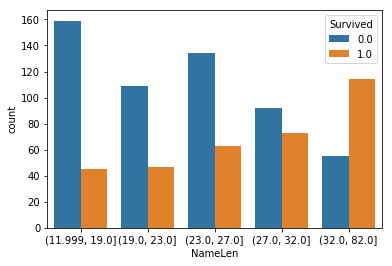

In [28]:
#NameLength
#Passengers with longer names had a higher rate of survival
tit['NameLen']=tit.Name.apply(len)
test['NameLen']=test.Name.apply(len)
sns.countplot(x=pd.qcut(tit['NameLen'],5),hue="Survived", data=tit)
tit['Survived'].groupby(pd.qcut(tit['NameLen'],5)).mean()



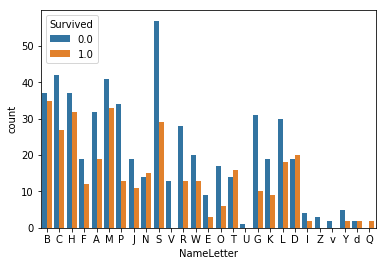

In [29]:
#NameLetter
tit['NameLetter'] = tit.Name.astype(str).str[0]
test['NameLetter']  = test.Name.astype(str).str[0]
plt.figure()
sns.countplot(x='NameLetter',hue="Survived", data=tit)

In [30]:

#LOGISTIC REGRESSION
#Set model
y=tit.Survived
x=tit[["Sex_female","CabinScale","Pclass","TitleScale","FamilyScale","TicketLenScale","TicketSum",'Youth']]
xtest=test[["Sex_female","CabinScale","Pclass","TitleScale","FamilyScale","TicketLenScale","TicketSum",'Youth']]
logisticRegr = LogisticRegression()
logisticRegr.fit(x, y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [31]:
#CV Model Evaluation
#I implemented a procedure to assess the quality of the logistic regression model using cross validation and the standard error of the parameters.
def model():
    global y
    global x
    y=tit["Survived"]
    logisticRegr = LogisticRegression()
    CVscores=sklearn.model_selection.cross_val_score(logisticRegr,x,y,cv=10)
    CVavg=np.mean(CVscores)
    CVstd=np.std(CVscores)
    ScorePrint=('Scores-',np.round(CVscores,4),'Average-',CVavg,'Std-',CVstd)
    print("SCORES-",np.round(CVscores,4),'\n')
    print("AVERAGE-",np.round(CVavg,4),'\n')
    print("STD.DEV.-",np.round(CVstd,4),'\n')
    logit_model=sm.Logit(y,x)
    result=logit_model.fit()
    print(result.summary2())

In [32]:
model()
#The most accurate logistic regression model I formulated contained several statistically insignifigant factors.  However, this is the logistic model which achieved the highest train and test scores.

SCORES- [0.8111 0.8444 0.7978 0.8539 0.8315 0.809  0.8539 0.8315 0.8427 0.8295] 

AVERAGE- 0.8305 

STD.DEV.- 0.0183 

Optimization terminated successfully.
         Current function value: 0.429806
         Iterations 6
                         Results: Logit
Model:              Logit            Pseudo R-squared: 0.355     
Dependent Variable: Survived         AIC:              781.9148  
Date:               2019-03-26 10:26 BIC:              820.2535  
No. Observations:   891              Log-Likelihood:   -382.96   
Df Model:           7                LL-Null:          -593.33   
Df Residuals:       883              LLR p-value:      8.4809e-87
Converged:          1.0000           Scale:            1.0000    
No. Iterations:     6.0000                                       
-----------------------------------------------------------------
                   Coef.  Std.Err.    z    P>|z|   [0.025  0.975]
-----------------------------------------------------------------
Sex_female   

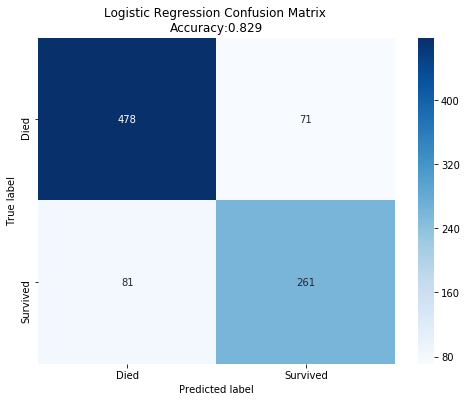

In [33]:
#Confusion Matrix
Y_fitted=pd.Series(logisticRegr.predict(x))

cm_df = pd.DataFrame(confusion_matrix(y, Y_fitted),
                     index = ['Died','Survived'], 
                     columns = ['Died','Survived'])
plt.figure(figsize=(8,6))
sns.heatmap(cm_df,annot=True,cmap='Blues', fmt='g')
plt.title('Logistic Regression Confusion Matrix \nAccuracy:{0:.3f}'.format(logisticRegr.score(x, tit.Survived)))
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()


In [34]:
#RANDOM FORESTS
#Set Continous Variables
Train_RF=tit[['Fare','NameLen','Age']]
Test_RF=test[['Fare','NameLen','Age']]

#Create and add dummy variables
columns = ['Pclass', 'CabinScale', 'TitleScale','TicketSum','Sex','Embarked','FamilyScale']
for column in columns:
    Train_RF[column] = tit[column].apply(lambda x: str(x))
    Test_RF[column] = test[column].apply(lambda x: str(x))
    good_cols = [column+'_'+i for i in Train_RF[column].unique() if i in Test_RF[column].unique()]
    Train_RF= pd.concat((Train_RF, pd.get_dummies(Train_RF[column], prefix = column)[good_cols]), axis = 1)
    Test_RF = pd.concat((Test_RF, pd.get_dummies(Test_RF[column], prefix = column)[good_cols]), axis = 1)

#Drop Unneeded Variables
Test_RF=Test_RF.drop(['Pclass', 'CabinScale', 'TitleScale','TicketSum','Sex','Embarked','FamilyScale'], axis=1)
Train_RF=Train_RF.drop(['Pclass', 'CabinScale', 'TitleScale','TicketSum','Sex','Embarked','FamilyScale'], axis=1)

#SetModel
y=tit["Survived"]

In [35]:
#Gridsearch for optimal RF hyperparameters
rf = RandomForestClassifier(max_features='auto',
                                oob_score=True,
                                random_state=1,
                                n_jobs=-1)

param_grid = { "criterion"   : ["gini", "entropy"],
             "min_samples_leaf" : [1, 5, 10],
             "min_samples_split" : [ 10, 12, 16],
             "n_estimators": [50, 100, 400]}

gs = GridSearchCV(estimator=rf,
                  param_grid=param_grid,
                  scoring='accuracy',
                  cv=3,
                  n_jobs=-1)

#Fit optimal model and print score
gs = gs.fit(Train_RF, y)
print(gs.best_score_)
print(gs.best_params_)

0.8316498316498316
{'criterion': 'gini', 'min_samples_leaf': 1, 'min_samples_split': 12, 'n_estimators': 100}


In [36]:
#Define RF model with optimal hyperparameters
rf = RandomForestClassifier(criterion='gini', 
                             n_estimators=100,
                             min_samples_split=10,
                             min_samples_leaf=1,
                             max_features='auto',
                             oob_score=True,
                             random_state=1,
			     n_jobs=-1)

#Fit Model                             
rf.fit(Train_RF, y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=10,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
            oob_score=True, random_state=1, verbose=0, warm_start=False)

In [37]:

#Calculate variable importance
results=pd.concat((pd.DataFrame(Train_RF.columns, columns = ['variable']), 
pd.DataFrame(rf.feature_importances_, columns = ['importance'])), 
axis = 1).sort_values(by='importance', ascending = False)[:20]
print(results)

         variable  importance
21       Sex_male    0.123024
0            Fare    0.107344
1         NameLen    0.105830
2             Age    0.097721
22     Sex_female    0.095039
9    TitleScale_4    0.086456
8    TitleScale_1    0.080302
3        Pclass_3    0.046111
7    CabinScale_2    0.033462
6    CabinScale_1    0.029077
4        Pclass_1    0.022791
26  FamilyScale_1    0.019619
5        Pclass_2    0.019604
23     Embarked_S    0.015899
27  FamilyScale_2    0.013842
10   TitleScale_3    0.012929
12    TicketSum_1    0.012461
15    TicketSum_3    0.012019
24     Embarked_C    0.009846
14    TicketSum_5    0.008039


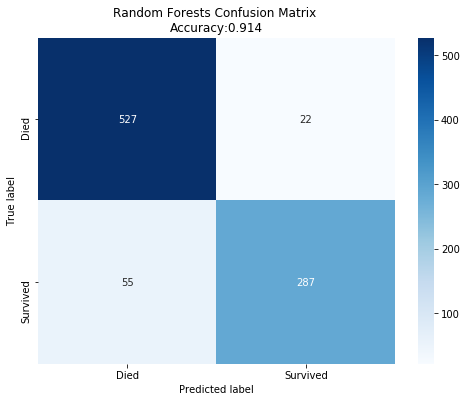

In [38]:
#Confusion Matrix
#Random Forests appears to perform better on the training data than Logistic regression, although there may be some overfitting.
#RF was used for the final prediction, which scored .80382.
Y_fitted=pd.Series(rf.predict(Train_RF))

cm_df = pd.DataFrame(confusion_matrix(y, Y_fitted),
                     index = ['Died','Survived'], 
                     columns = ['Died','Survived'])
plt.figure(figsize=(8,6))
sns.heatmap(cm_df,annot=True,cmap='Blues', fmt='g')
plt.title('Random Forests Confusion Matrix \nAccuracy:{0:.3f}'.format(rf.score(Train_RF, tit.Survived)))
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()



In [39]:
#Predict Values
Y_pred_rf=rf.predict(Test_RF)
submission_RF = pd.DataFrame({'PassengerId':test['PassengerId'],'Survived':Y_pred_rf})

In [27]:
submission_RF

PassengerId  Survived
891           892       0.0
892           893       0.0
893           894       0.0
894           895       0.0
895           896       1.0
896           897       0.0
897           898       1.0
898           899       0.0
899           900       1.0
900           901       0.0
901           902       0.0
902           903       0.0
903           904       1.0
904           905       0.0
905           906       1.0
906           907       1.0
907           908       0.0
908           909       0.0
909           910       0.0
910           911       1.0
911           912       0.0
912           913       1.0
913           914       1.0
914           915       0.0
915           916       1.0
916           917       0.0
917           918       1.0
918           919       0.0
919           920       0.0
920           921       0.0
...           ...       ...
1279         1280       0.0
1280         1281       0.0
1281         1282       0.0
1282         1283       1.0
1283         1284       1.0
1284         1285       0.0
1285         1286       0.0
1286         1287       1.0
1287         1288       0.0
1288         1289       1.0
1289         1290       0.0
1290         1291       0.0
1291         1292       1.0
1292         1293       0.0
1293         1294       1.0
1294         1295       0.0
1295         1296       0.0
1296         1297       1.0
1297         1298       0.0
1298         1299       0.0
1299         1300       1.0
1300         1301       1.0
1301         1302       1.0
1302         1303       1.0
1303         1304       0.0
1304         1305       0.0
1305         1306       1.0
1306         1307       0.0
1307         1308       0.0
1308         1309       1.0

[418 rows x 2 columns]

In [40]:
submission_RF.to_csv("titanic_submission.csv", index=None)